<a href="https://colab.research.google.com/github/sromanov103/covid_19/blob/main/Recognizing_(Covid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

In [ ]:
!pip install opendatasets


*   username: romanovsergei
*   key: a094cffea6288dc273a5aed49b288462

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: romanovsergei
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:35<00:00, 22.7MB/s]


In [ ]:
# Пути к папкам с изображениями и масками
dataset_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'
image_patch = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
image_masks = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks'
image_covid = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
image_covid_masks = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks'

In [ ]:
# Обход дерева директорий, начиная с `image_patch`, и сбор всех путей к файлам
inp_list = []

for dirpath, dirs, filenames in os.walk(image_patch):
  for filename in filenames:
    inp_list.append(os.path.join(dirpath, filename))

inp_list = sorted(inp_list)

print(inp_list[:3])

['/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png',
 '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10.png',
 '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-100.png']

In [ ]:
mask_list = []

for dirpath, dirs, filenames in os.walk(image_masks):
  for filename in filenames:
    mask_list.append(os.path.join(dirpath, filename))

mask_list = sorted(mask_list)
mask_list[:3]

['/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-1.png',
 '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-10.png',
 '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-100.png']

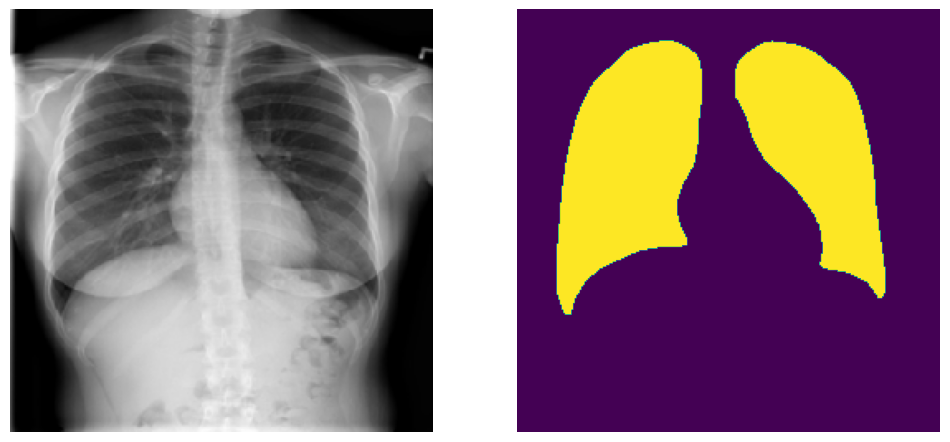

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

img = np.array(load_img(inp_list[7], target_size=(256, 256), color_mode='rgb'))
mask = np.array(load_img(mask_list[7], target_size=(256, 256), color_mode='grayscale'))

ax[0].imshow(img)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off');

In [ ]:
# Разделение списка путей к файлам на тренировочный, валидационный и тестовый наборы
spl1 = 7000
spl2 = 8500

# Создание тренировочного набора из первых 7000 элементов списка
train_paths = tf.data.Dataset.from_tensor_slices((inp_list[:spl1], mask_list[:spl1]))

# Создание валидационного набора из следующих 1500 элементов списка (от 7000 до 8500)
val_paths = tf.data.Dataset.from_tensor_slices((inp_list[spl1:spl2], mask_list[spl1:spl2]))

# Создание тестового набора из оставшихся элементов списка (от 8500 до конца)
test_paths = tf.data.Dataset.from_tensor_slices((inp_list[spl2:], mask_list[spl2:]))

In [ ]:
# Определение размеров изображения и размера батча
img_height = 128
img_width = 128
batch = 64

# Функция загрузки и обработки изображений и масок
def load_data(im_path, masks_path):
  image = tf.io.read_file(im_path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, [img_height, img_width])
  image = image / 255.0

  # Загрузка маски
  mask = tf.io.read_file(masks_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, [img_height, img_width])
  mask = mask / 255.0

  return image, mask

In [ ]:
# Создание датасетов для тренировки, валидации и тестирования
train_ds = train_paths.map(load_data, num_parallel_calls=tf.data.AUTOTUNE).batch(batch).prefetch(1)
val_ds =  val_paths.map(load_data, num_parallel_calls=tf.data.AUTOTUNE).batch(batch).prefetch(1)
test_ds = test_paths.map(load_data, num_parallel_calls=tf.data.AUTOTUNE).batch(batch).prefetch(1)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Энкодер
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Декодер
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    up1 = UpSampling2D(size=(2, 2))(conv4)
    merge1 = Concatenate()([conv3, up1])

    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    up2 = UpSampling2D(size=(2, 2))(conv5)
    merge2 = Concatenate()([conv2, up2])

    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    up3 = UpSampling2D(size=(2, 2))(conv6)
    merge3 = Concatenate()([conv1, up3])

    # Выходной слой
    conv7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(merge3)

    model = Model(inputs=[inputs], outputs=[conv7])

    return model

input_shape = (128, 128, 3)
model = build_unet(input_shape)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 128, 128, 32)   │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_116[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 64, 64, 32)     │              0 │ conv2d_117[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 64, 64, 64)     │         36,928 │ conv2d_118[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 32, 32, 64)     │              0 │ conv2d_119[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 32, 32, 128)    │        147,584 │ conv2d_120[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 16, 16, 128)    │              0 │ conv2d_121[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 16, 16, 128)    │        147,584 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_123 (Conv2D)       │ (None, 16, 16, 128)    │        147,584 │ conv2d_122[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_6           │ (None, 32, 32, 128)    │              0 │ conv2d_123[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_24            │ (None, 32, 32, 256)    │              0 │ conv2d_121[0][0],      │
│ (Concatenate)             │                        │                │ up_sampling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_124 (Conv2D)       │ (None, 32, 32, 64)     │        147,520 │ concatenate_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_125 (Conv2D)       │ (None, 32, 32, 64)     │         36,928 │ conv2d_124[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_7      

 Total params: 813,345 (3.10 MB)

 Trainable params: 813,345 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Скомпилируйте модель
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)
]
# Загрузите обучающие данные
train_ds = train_paths.map(load_data, num_parallel_calls=tf.data.AUTOTUNE).batch(batch).prefetch(1)
val_ds = val_paths.map(load_data, num_parallel_calls=tf.data.AUTOTUNE).batch(batch).prefetch(1)
test_ds = test_paths.map(load_data, num_parallel_calls=tf.data.AUTOTUNE).batch(batch).prefetch(1)

In [ ]:
# Обучите модель
history = model.fit(train_ds,
          epochs=10,
          validation_data=val_ds,
          batch_size=16
          )

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - accuracy: 0.9825 - loss: 0.0193 - val_accuracy: 0.9825 - val_loss: 0.0199
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.9585 - loss: 0.0952 - val_accuracy: 0.7472 - val_loss: 0.4074
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 0.8767 - loss: 0.2455 - val_accuracy: 0.9603 - val_loss: 0.0807
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9631 - loss: 0.0721 - val_accuracy: 0.9684 - val_loss: 0.0584
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - accuracy: 0.9706 - loss: 0.0520 - val_accuracy: 0.9724 - val_loss: 0.0477
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.9744 - loss: 0.0421 - val_accuracy: 0.9744 - val_loss: 0.0430
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.9762 - loss: 0.0374 - val_accuracy: 0.9769 - val_loss: 0.0368
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.9774 - loss: 0

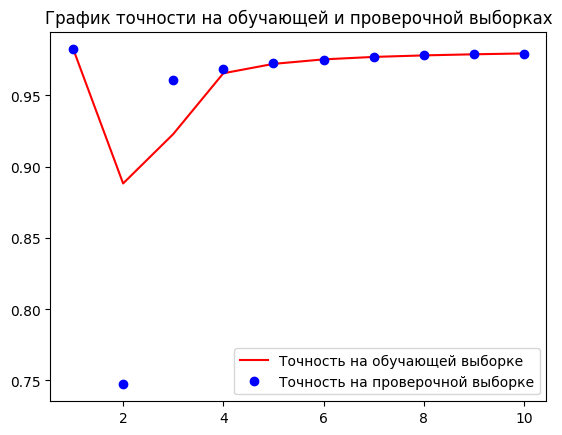

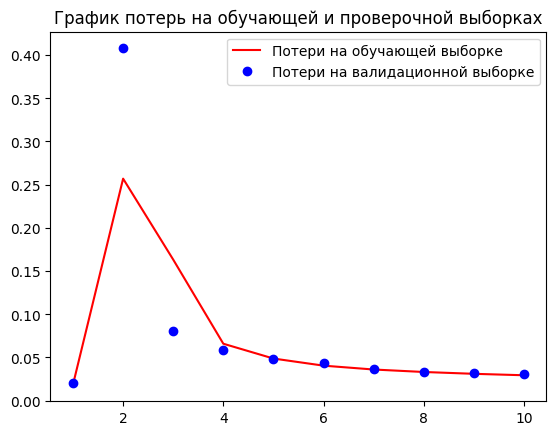

In [ ]:
acc = history.history['accuracy']                       # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']               # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step


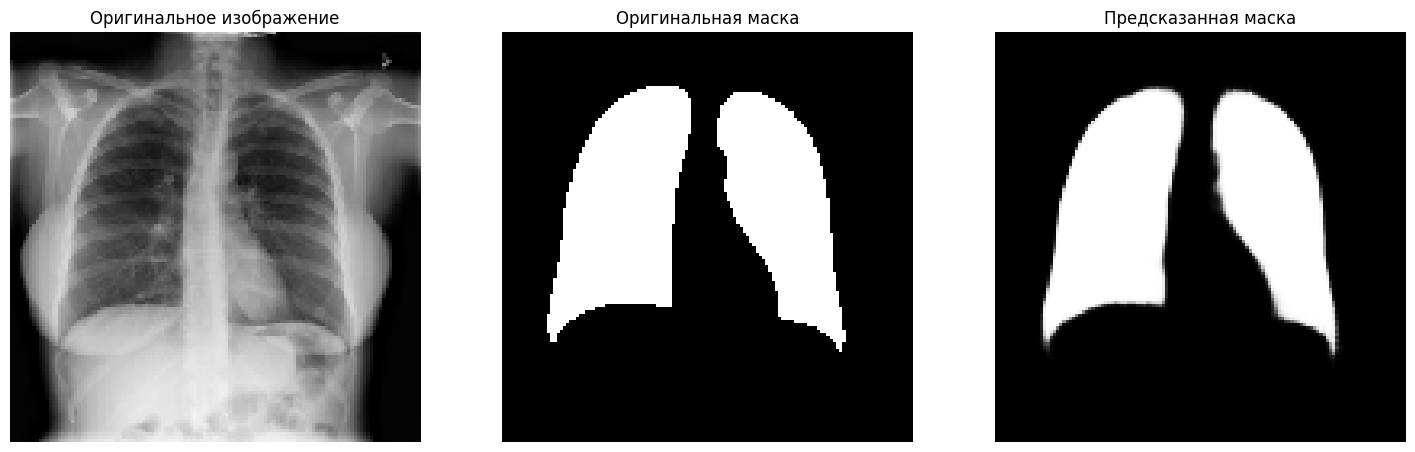

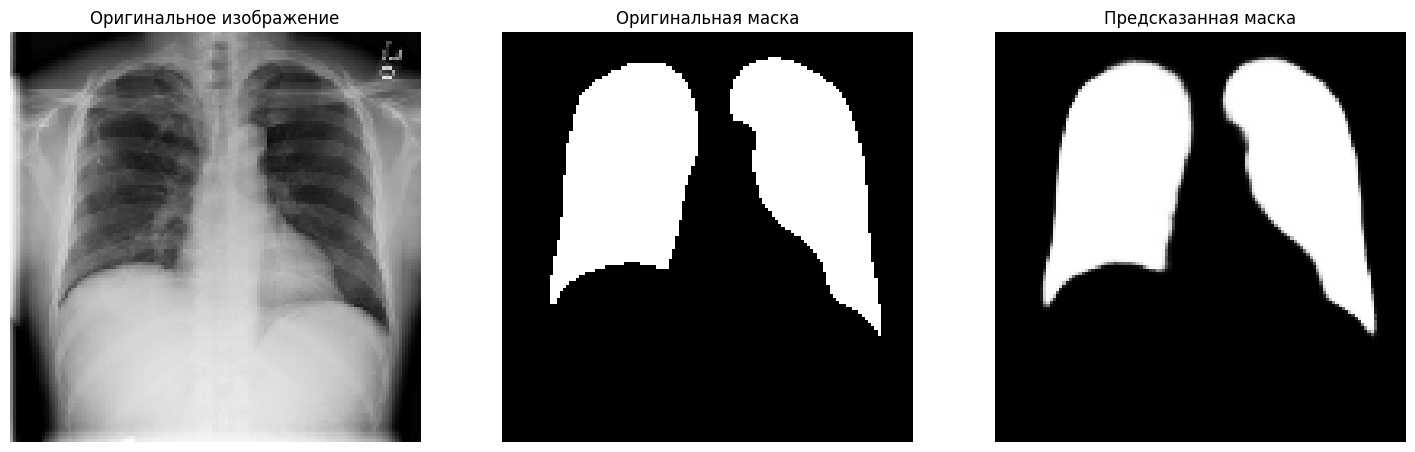

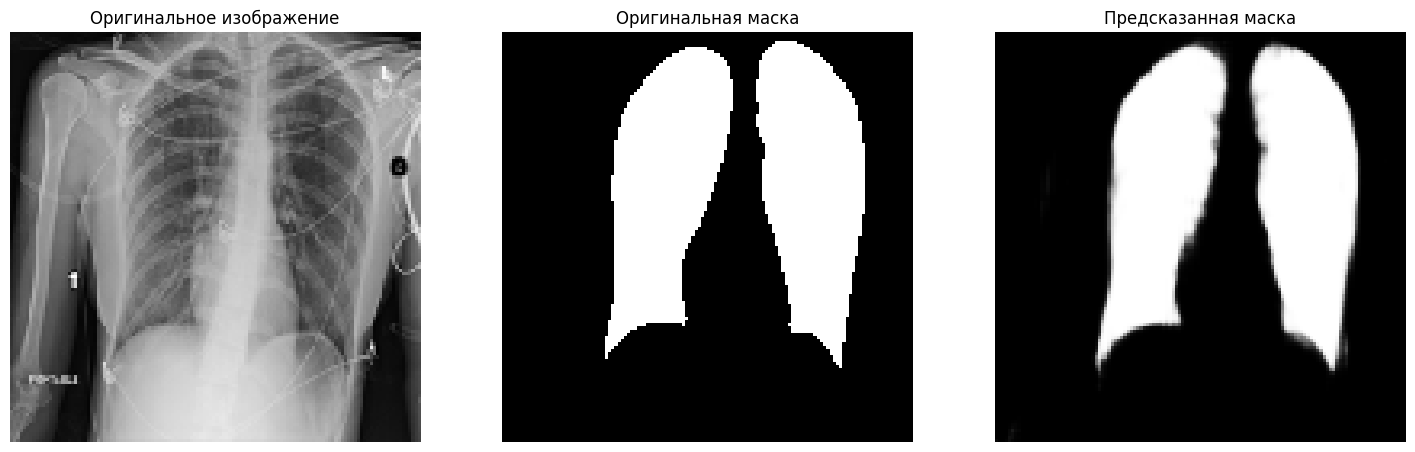

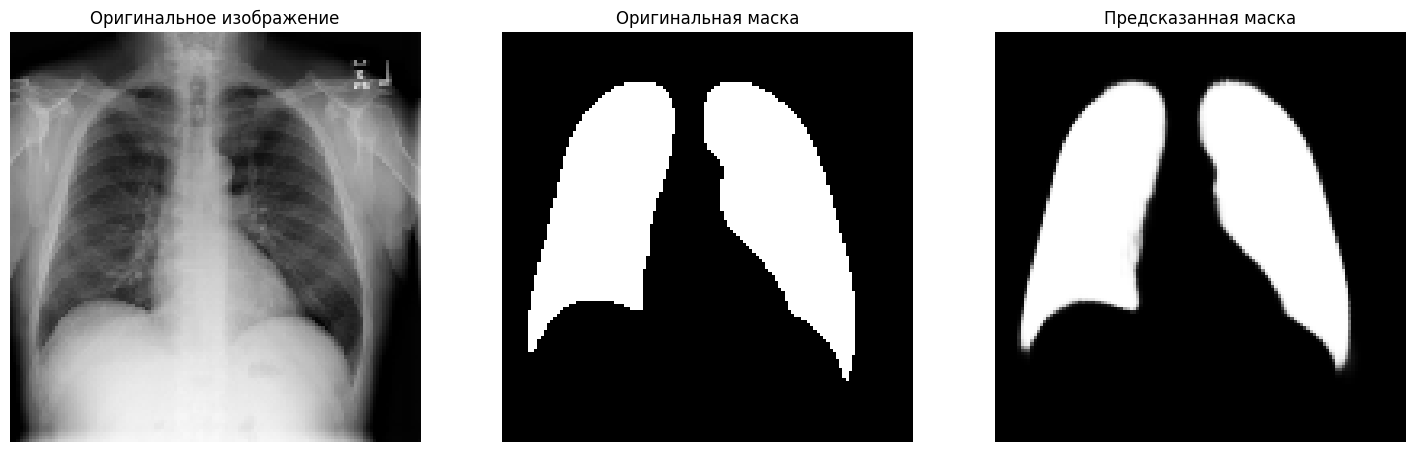

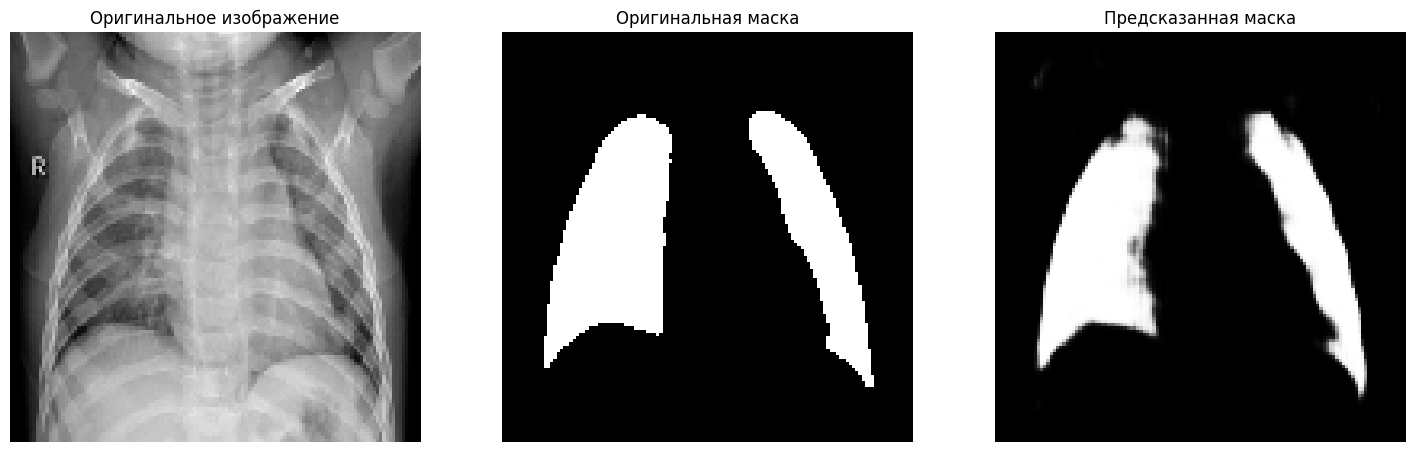

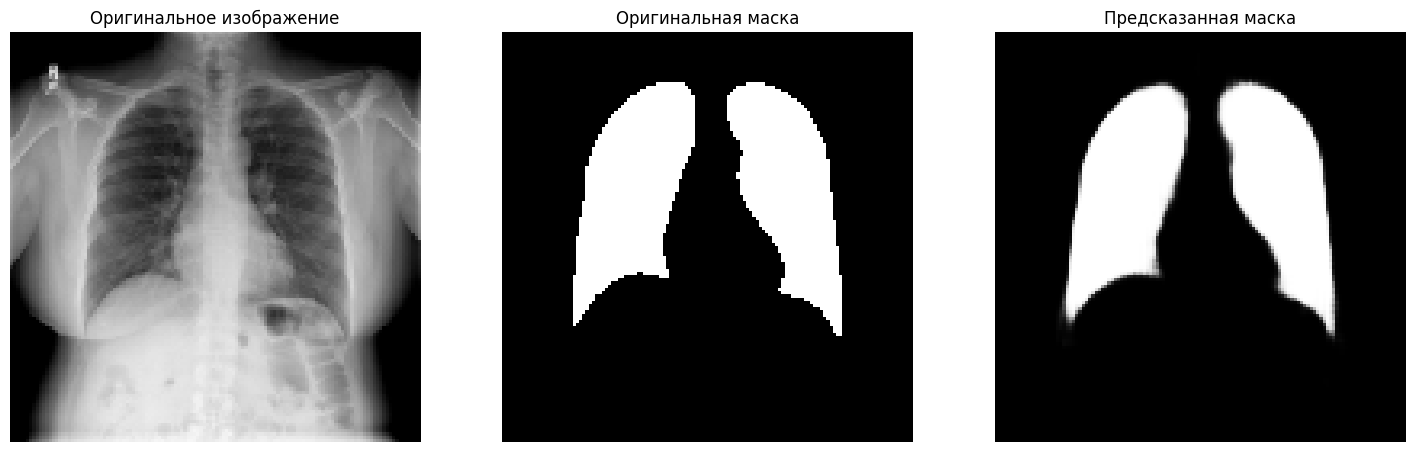

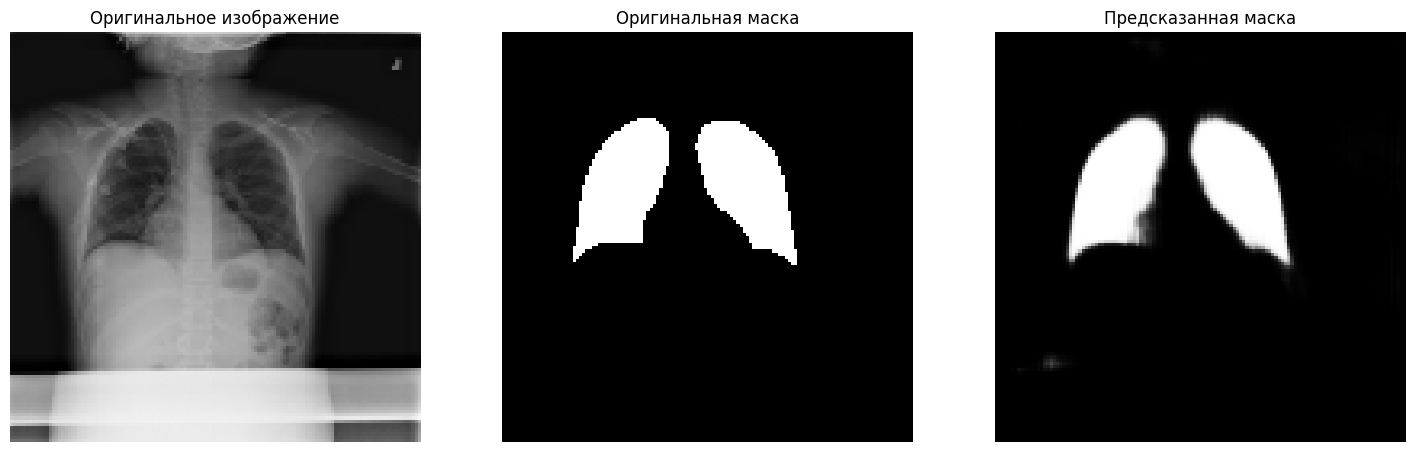

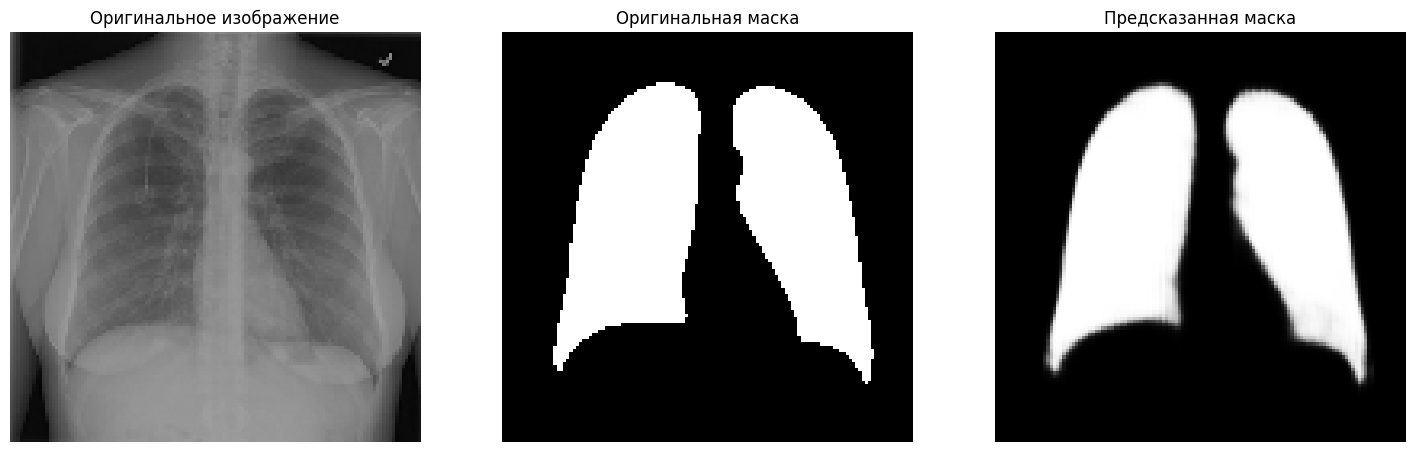

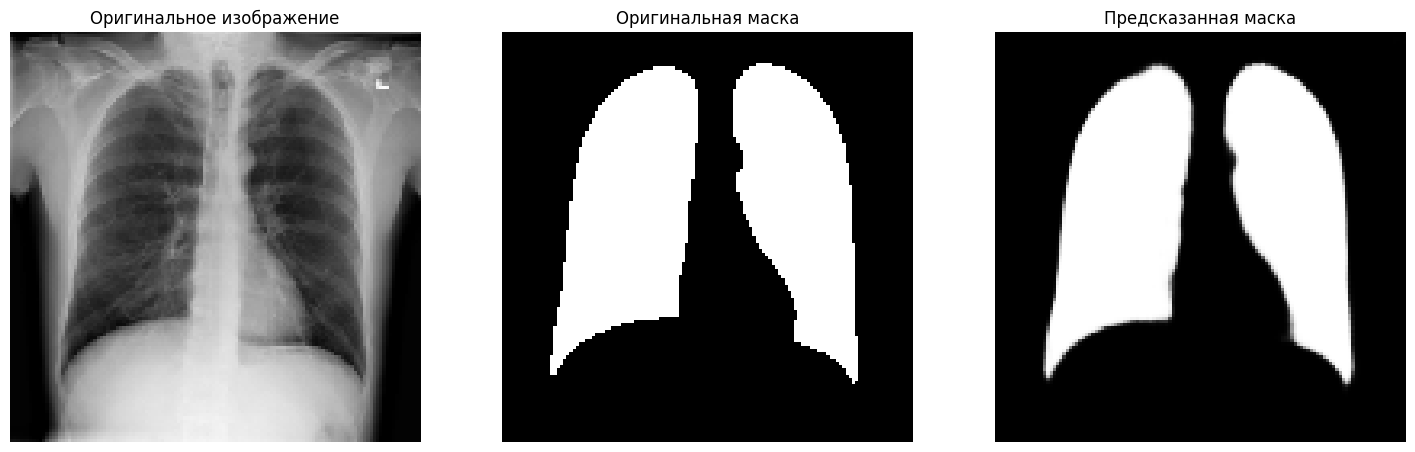

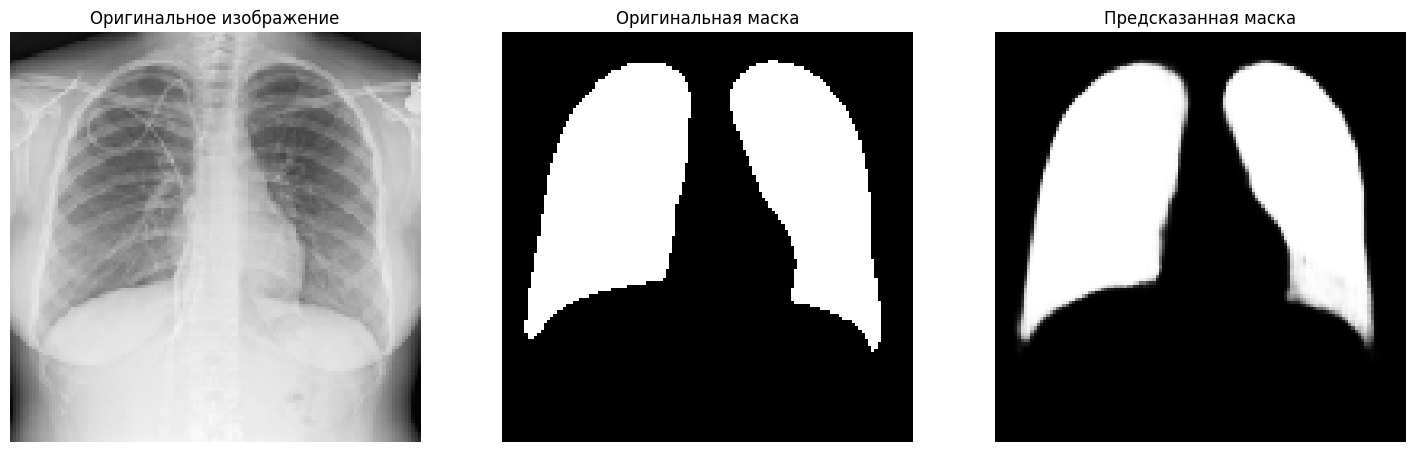

In [ ]:
import matplotlib.pyplot as plt

# Делаем предсказание
predictions = model.predict(test_ds)

# Отобразим 10 изображений
for i in range(10):
    img = np.array(load_img(inp_list[spl2 + i], target_size=(128, 128), color_mode='rgb'))
    mask = np.array(load_img(mask_list[spl2 + i], target_size=(128, 128), color_mode='grayscale'))
    pred_mask = predictions[i] * 255.0

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(img)
    ax[1].imshow(mask, cmap='gray')
    ax[2].imshow(pred_mask, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[0].set_title('Оригинальное изображение')
    ax[1].set_title('Оригинальная маска')
    ax[2].set_title('Предсказанная маска')
    plt.show()